# Homework #4 

In [1]:
# Description of the project for me to refer to.
# Use a model that considers a family’s observable attributes to classify them and predict their level of need.

# Part 1 | Import Packages & the Data Set

In [2]:
# First I need to import various packages to get set up for the project
import datetime
import gc
import numpy as np
import os
import operator
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import describe
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, mean_squared_error
from sklearn.model_selection import KFold, RepeatedKFold, GroupKFold
from imblearn.under_sampling import RandomUnderSampler
import lightgbm as lgb
import xgboost as xgb

/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [3]:
# import the data set | 
train = pd.read_csv("/Users/hunterromano/Desktop/train.csv")

# look at data to make sure it was imported and correct
train.head(5)

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,...,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,...,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,...,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,...,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,...,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


# Part 2 | Clean & Explore the Data

In [4]:
# I want a full list of the attributes in the set
# I can understand what data points I have and how to move forward
train.dtypes

Id                  object
v2a1               float64
hacdor               int64
rooms                int64
hacapo               int64
v14a                 int64
refrig               int64
v18q                 int64
v18q1              float64
r4h1                 int64
r4h2                 int64
r4h3                 int64
r4m1                 int64
r4m2                 int64
r4m3                 int64
r4t1                 int64
r4t2                 int64
r4t3                 int64
tamhog               int64
tamviv               int64
escolari             int64
rez_esc            float64
hhsize               int64
paredblolad          int64
paredzocalo          int64
paredpreb            int64
pareddes             int64
paredmad             int64
paredzinc            int64
paredfibras          int64
                    ...   
bedrooms             int64
overcrowding       float64
tipovivi1            int64
tipovivi2            int64
tipovivi3            int64
tipovivi4            int64
t

In [5]:
# I want a better understanding of the values 
train.describe()

,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
count,2.697000e+03,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,2215.000000,9557.000000,9557.000000,...,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9552.000000,9557.000000,9557.000000
mean,1.652316e+05,0.038087,4.955530,0.023648,0.994768,0.957623,0.231767,1.404063,0.385895,1.559171,...,74.222769,1643.774302,19.132887,53.500262,3.844826,3.249485,3.900409,102.588867,1643.774302,3.302292
std,1.504571e+05,0.191417,1.468381,0.151957,0.072145,0.201459,0.421983,0.763131,0.680779,1.036574,...,76.777549,1741.197050,18.751395,78.445804,6.946296,4.129547,12.511831,93.516890,1741.197050,1.009565
min,0.000000e+00,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.040000,0.000000,0.000000,0.000000,1.000000
25%,8.000000e+04,0.000000,4.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,...,16.000000,289.000000,9.000000,0.000000,0.000000,1.000000,0.111111,36.000000,289.000000,3.000000
50%,1.300000e+05,0.000000,5.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,...,36.000000,961.000000,16.000000,36.000000,1.000000,2.250000,0.444444,81.000000,961.000000,4.000000
75%,2.000000e+05,0.000000,6.000000,0.000000,1.000000,1.000000,0.000000,2.000000,1.000000,2.000000,...,121.000000,2601.000000,25.000000,81.000000,4.000000,4.000000,1.777778,134.560010,2601.000000,4.000000
max,2.353477e+06,1.000000,11.000000,1.000000,1.000000,1.000000,1.000000,6.000000,5.000000,8.000000,...,441.000000,9409.000000,169.000000,441.000000,81.000000,36.000000,64.000000,1369.000000,9409.000000,4.000000


In [6]:
# More views
train.head().transpose()

,0,1,2,3,4
Id,ID_279628684,ID_f29eb3ddd,ID_68de51c94,ID_d671db89c,ID_d56d6f5f5
v2a1,190000,135000,NaN,180000,180000
hacdor,0,0,0,0,0
rooms,3,4,8,5,5
hacapo,0,0,0,0,0
v14a,1,1,1,1,1
refrig,1,1,1,1,1
v18q,0,1,0,1,1
v18q1,NaN,1,NaN,1,1
r4h1,0,0,0,0,0


In [7]:
#shape of data
print('training_data:',train.shape)


training_data: (9557, 143)


# Take care of missing values

In [8]:
train.isnull().values.any()

True

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9557 entries, 0 to 9556
Columns: 143 entries, Id to Target
dtypes: float64(8), int64(130), object(5)
memory usage: 10.4+ MB


In [10]:
train.isnull().values.sum(axis=0)

array([   0, 6860,    0,    0,    0,    0,    0,    0, 7342,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0, 7928,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    5,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    5,    0,    0])

In [11]:
train_describe = train.describe()
train_describe

,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
count,2.697000e+03,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,2215.000000,9557.000000,9557.000000,...,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9552.000000,9557.000000,9557.000000
mean,1.652316e+05,0.038087,4.955530,0.023648,0.994768,0.957623,0.231767,1.404063,0.385895,1.559171,...,74.222769,1643.774302,19.132887,53.500262,3.844826,3.249485,3.900409,102.588867,1643.774302,3.302292
std,1.504571e+05,0.191417,1.468381,0.151957,0.072145,0.201459,0.421983,0.763131,0.680779,1.036574,...,76.777549,1741.197050,18.751395,78.445804,6.946296,4.129547,12.511831,93.516890,1741.197050,1.009565
min,0.000000e+00,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.040000,0.000000,0.000000,0.000000,1.000000
25%,8.000000e+04,0.000000,4.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,...,16.000000,289.000000,9.000000,0.000000,0.000000,1.000000,0.111111,36.000000,289.000000,3.000000
50%,1.300000e+05,0.000000,5.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,...,36.000000,961.000000,16.000000,36.000000,1.000000,2.250000,0.444444,81.000000,961.000000,4.000000
75%,2.000000e+05,0.000000,6.000000,0.000000,1.000000,1.000000,0.000000,2.000000,1.000000,2.000000,...,121.000000,2601.000000,25.000000,81.000000,4.000000,4.000000,1.777778,134.560010,2601.000000,4.000000
max,2.353477e+06,1.000000,11.000000,1.000000,1.000000,1.000000,1.000000,6.000000,5.000000,8.000000,...,441.000000,9409.000000,169.000000,441.000000,81.000000,36.000000,64.000000,1369.000000,9409.000000,4.000000


In [12]:
train.isnull().values.sum(axis=0)

array([   0, 6860,    0,    0,    0,    0,    0,    0, 7342,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0, 7928,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    5,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    5,    0,    0])

# Look into the target variables

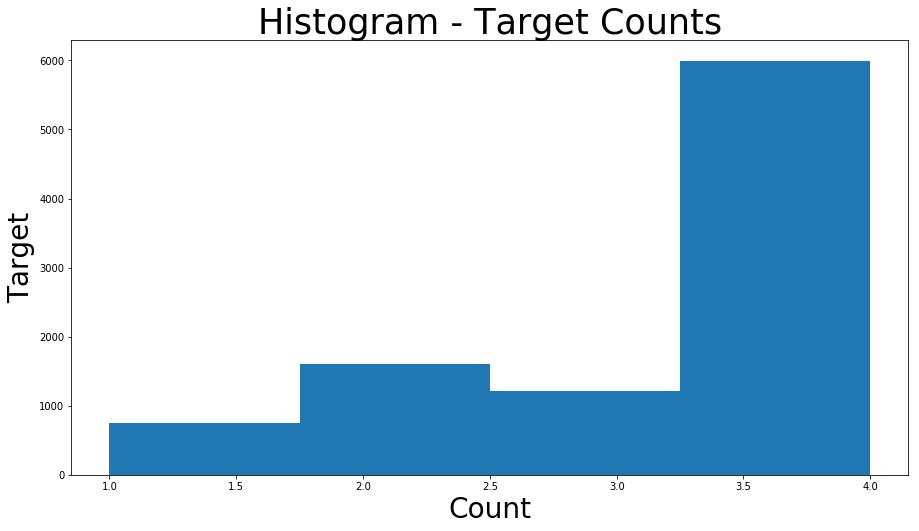

In [13]:
plt.figure(figsize=(15, 8))
plt.hist(train.Target.values, bins=4)
plt.title('Histogram - Target Counts', fontsize=35)
plt.xlabel('Count', fontsize=28)
plt.ylabel('Target', fontsize=28)
plt.show()

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


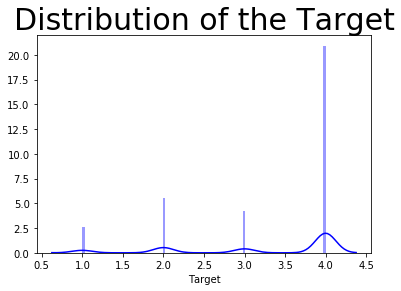

In [14]:
plt.title("Distribution of the Target", fontsize=30)
sns.distplot(train['Target'].dropna(),color='blue', kde = True, bins=100)
plt.show()

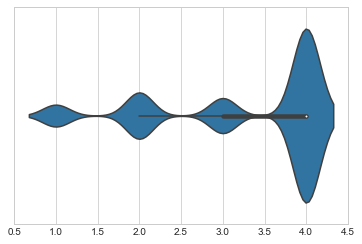

In [15]:
sns.set_style("whitegrid")
ax = sns.violinplot(x=train.Target.values)
plt.show()

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


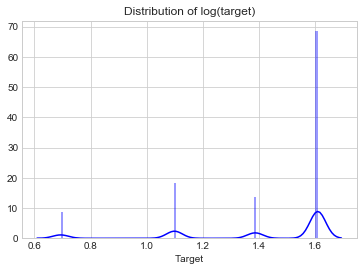

In [16]:
plt.title("Distribution of log(target)")
sns.distplot(np.log1p(train['Target']).dropna(),color='blue', kde=True, bins=100)
plt.show()

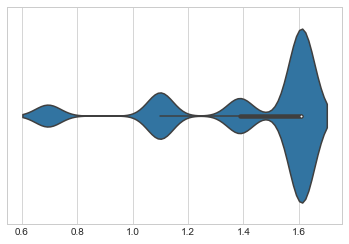

In [17]:
sns.set_style("whitegrid")
ax = sns.violinplot(x=np.log(1+train.Target.values))
plt.show()

In [18]:
np.unique(train.Target.values)

array([1, 2, 3, 4])

In [19]:
columns_functional = train.columns[1:-1]

In [20]:
columns_functional

Index(['v2a1', 'hacdor', 'rooms', 'hacapo', 'v14a', 'refrig', 'v18q', 'v18q1',
       'r4h1', 'r4h2',
       ...
       'age', 'SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe',
       'SQBhogar_nin', 'SQBovercrowding', 'SQBdependency', 'SQBmeaned',
       'agesq'],
      dtype='object', length=141)

In [21]:
y = train['Target'].values-1

In [22]:
# I want to bring in my test data to clean it at the same time.
test = pd.read_csv("/Users/hunterromano/Desktop/test.csv")

In [23]:
test.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq
0,ID_2f6873615,NaN,0,5,0,1,1,0,NaN,1,...,4,0,16,9,0,1,2.25,0.25,272.25,16
1,ID_1c78846d2,NaN,0,5,0,1,1,0,NaN,1,...,41,256,1681,9,0,1,2.25,0.25,272.25,1681
2,ID_e5442cf6a,NaN,0,5,0,1,1,0,NaN,1,...,41,289,1681,9,0,1,2.25,0.25,272.25,1681
3,ID_a8db26a79,NaN,0,14,0,1,1,1,1.0,0,...,59,256,3481,1,256,0,1.00,0.00,256.00,3481
4,ID_a62966799,175000.0,0,4,0,1,1,1,1.0,0,...,18,121,324,1,0,1,0.25,64.00,NaN,324


In [24]:
train_test_df = pd.concat([train[columns_functional], test[columns_functional]], axis=0)
# Identify the columns that contain categorical data
categorical_columns = [f_ for f_ in train_test_df.columns if train_test_df[f_].dtype == 'object']


In [26]:
# Take a look at them
categorical_columns

['idhogar', 'dependency', 'edjefe', 'edjefa']

In [28]:
# Now I need to label my different columns
for col in categorical_columns:
    le = LabelEncoder()
    print(col)
    le.fit(train_test_df[col].astype(str))
    train[col] = le.transform(train[col].astype(str))
    test[col] = le.transform(test[col].astype(str))
    del le

idhogar


ValueError: y contains previously unseen labels: '1321'

In [29]:
def dprint(*args, **kwargs):
    print("[{}] ".format(datetime.datetime.now().strftime("%Y-%m-%d %H:%M")) + \
        " ".join(map(str,args)), **kwargs)

id = 'Id'

target = 'Target'

df_all = pd.concat([train, test], axis=0)
cols = [f_ for f_ in df_all.columns if df_all[f_].dtype == 'object' and f_ != id]
print(cols)

for c in tqdm(cols):
    le = preprocessing.LabelEncoder()
    le.fit(df_all[c].astype(str))
    train_df[c] = le.transform(train[c].astype(str))
    test_df[c] = le.transform(test[c].astype(str))

    del le
gc.collect()

def extract_features(df):
    df['bedrooms_to_rooms'] = df['bedrooms']/df['rooms']
    df['rent_to_rooms'] = df['v2a1']/df['rooms']
    df['tamhog_to_rooms'] = df['tamhog']/df['rooms']

extract_features(train)
extract_features(test)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  
0it [00:00, ?it/s]

[]


/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3184: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


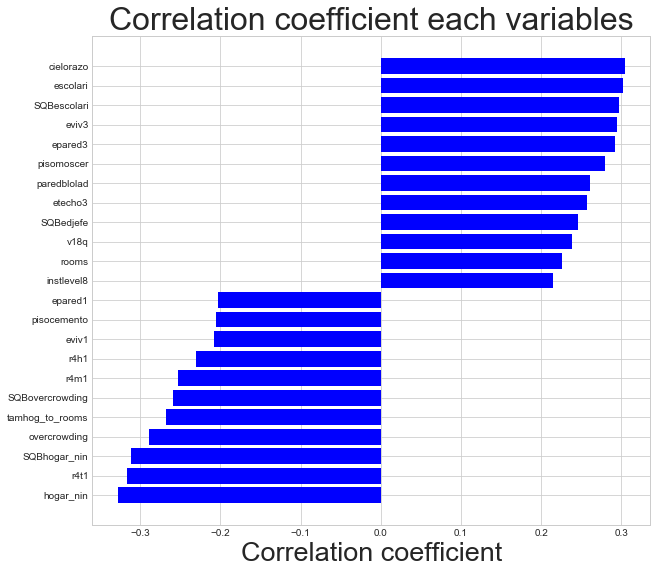

In [30]:
# Find correlated varaibles with target
labels = []
values = []
for col in train.columns:
    if col not in ["Id", "Target"]:
        labels.append(col)
        values.append(np.corrcoef(train[col].values, train["Target"].values)[0,1])
corr_df = pd.DataFrame({'columns_labels':labels, 'corr_values':values})
corr_df = corr_df.sort_values(by='corr_values')
 
corr_df = corr_df[(corr_df['corr_values']>0.20) | (corr_df['corr_values']<-0.20)]
ind = np.arange(corr_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(10,9))
rects = ax.barh(ind, np.array(corr_df.corr_values.values), color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(corr_df.columns_labels.values, rotation='horizontal')
ax.set_xlabel("Correlation coefficient", fontsize=27)
ax.set_title("Correlation coefficient each variables", fontsize=32)
plt.show()

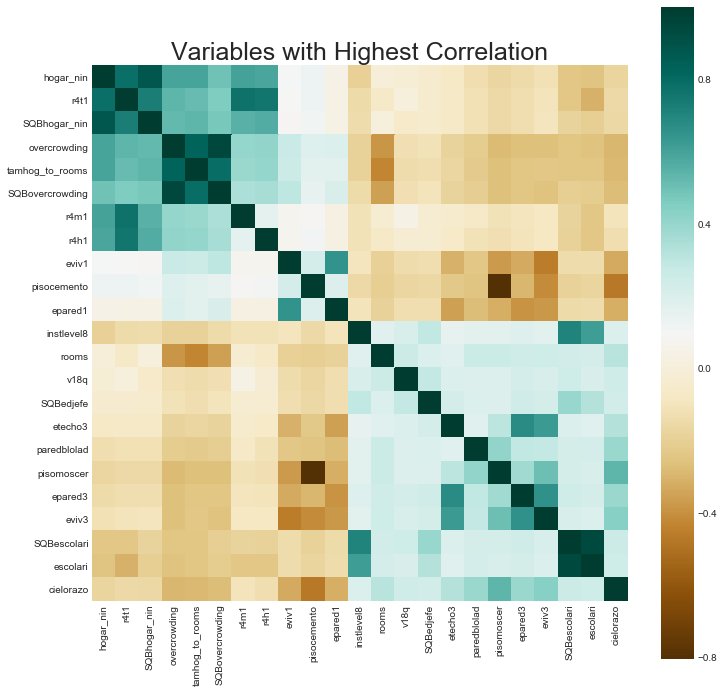

In [31]:
#Matrix of the variables with the highest correlation
temp = train[corr_df.columns_labels.tolist()]
correlation_map = temp.corr(method='pearson')
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(correlation_map, vmax=1., square=True, cmap=plt.cm.BrBG)
plt.title("Variables with Highest Correlation", fontsize=25)
plt.show()

In [32]:
# Try forest hope data is good
train_undersampled=train.drop(train.query('Target == 4').sample(frac=.75).index)
train_undersampled

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target,bedrooms_to_rooms,rent_to_rooms,tamhog_to_rooms
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,...,0,0,0.250000,64.000000,121.000000,8464,4,0.250000,NaN,0.125000
8,ID_1284f8aad,130000.0,1,2,0,1,1,0,NaN,0,...,81,4,16.000000,1.000000,100.000000,900,4,0.500000,65000.000000,2.000000
15,ID_0a39e419e,90000.0,1,2,0,1,1,0,NaN,0,...,0,4,16.000000,9.000000,289.000000,361,4,0.500000,45000.000000,2.000000
16,ID_4ff51f90c,90000.0,1,2,0,1,1,0,NaN,0,...,0,4,16.000000,9.000000,289.000000,4900,4,0.500000,45000.000000,2.000000
19,ID_35b66f7c6,215000.0,0,4,0,1,1,0,NaN,0,...,225,0,1.000000,0.000000,182.250000,484,4,0.500000,53750.000000,0.500000
24,ID_298d857e5,100000.0,1,1,1,0,1,0,NaN,0,...,36,0,9.000000,0.000000,106.777770,400,4,1.000000,100000.000000,3.000000
32,ID_e24d9c3c9,NaN,0,5,0,1,1,0,NaN,0,...,121,1,2.777778,0.062500,27.562500,784,4,0.600000,NaN,1.000000
35,ID_beb36ce09,NaN,0,5,0,1,1,0,NaN,0,...,121,1,2.777778,0.062500,27.562500,361,4,0.600000,NaN,1.000000
38,ID_0f01e18e9,80000.0,0,4,0,1,1,0,NaN,0,...,64,1,2.250000,0.250000,49.000000,225,4,0.500000,20000.000000,0.750000
41,ID_1f68e9b45,90000.0,0,5,0,1,1,1,1.0,0,...,0,0,1.000000,0.000000,121.000000,576,4,0.400000,18000.000000,0.400000


In [33]:
X=train_undersampled.drop(['Id', 'idhogar', 'Target', 'edjefe', 'edjefa'], axis=1)
y=train_undersampled['Target']

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [35]:
X_train.shape


(4048, 141)

In [36]:
y_train.shape

(4048,)

In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [38]:
clf = RandomForestClassifier()
params={'n_estimators': list(range(40,61, 1))}
gs = GridSearchCV(clf, params, cv=5)


In [39]:
gs.fit(X_train, y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:542: FutureWarning: From version 0.22, errors during fit will result in a cross validation score of NaN by default. Use error_score='raise' if you want an exception raised or error_score=np.nan to adopt the behavior from version 0.22.
  FutureWarning)


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [41]:
# It looks like my data isn't clean enough to run a random forest unfortunately
# I tried cleaning it in various other ways but ended with the same result
#  I figured it would be better to try another model instead of just copying a perfect cleaning kernel that I didn't understand.
# So I did some research and found lightgbm, it didn't work for a while.
# I figured out that I had to install some new packages within the terminal to be able to run it.
# It took way longer than anticipated, but after several brew commands and pip installs my terminal is up-to-date

In [40]:
# Now time to run my Predictive Model

# The following code begins the lightgbm
cnt = 0
p_buf = []
n_splits = 20
n_repeats = 1
kf = RepeatedKFold(
    n_splits=n_splits, 
    n_repeats=n_repeats, 
    random_state=None)
err_buf = []   

cols_to_drop = [
    id, 
    target,
]
X = train.drop(cols_to_drop, axis=1, errors='ignore')
feature_names = list(X.columns)
X = X.fillna(0)
X = X.values
y = train[target].values

classes = np.unique(y)
dprint('Number of classes: {}'.format(len(classes)))
c2i = {}
i2c = {}
for i, c in enumerate(classes):
    c2i[c] = i
    i2c[i] = c

y_le = np.array([c2i[c] for c in y])

X_test = test.drop(cols_to_drop, axis=1, errors='ignore')
X_test = X_test.fillna(0)
X_test = X_test.values
id_test = test[id].values

dprint(X.shape, y.shape)
dprint(X_test.shape)

n_features = X.shape[1]

lgb_params = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'metric': 'multi_logloss',
    'max_depth': -1,
    'num_leaves': 14,
    'learning_rate': 0.1,
    'feature_fraction': 0.85,
    'bagging_fraction': 0.85,
    'bagging_freq': 5,
    'verbose': -1,
    'num_threads': 8,
    'colsample_bytree': 0.89,
    'min_child_samples': 90,
    'subsample': 0.96,
    'lambda_l2': 1.0,
    'min_gain_to_split': 0,
    'num_class': len(np.unique(y)),
}

[2018-11-06 10:07] Number of classes: 4
[2018-11-06 10:07] (9557, 144) (9557,)
[2018-11-06 10:07] (23856, 144)


In [42]:
#generate sampling with imblearn
sampler = RandomUnderSampler(random_state=314)
X, y = sampler.fit_sample(X, y)
y_le = np.array([c2i[c] for c in y])

for train_index, valid_index in kf.split(X, y):
    print('Fold {}/{}*{}'.format(cnt + 1, n_splits, n_repeats))
    params = lgb_params.copy() 

    lgb_train = lgb.Dataset(
        X[train_index], 
        y_le[train_index], 
        feature_name=feature_names,
        )
    lgb_train.raw_data = None

    lgb_valid = lgb.Dataset(
        X[valid_index], 
        y_le[valid_index],
        feature_name=feature_names,
        )
    lgb_valid.raw_data = None

    model = lgb.train(
        params,
        lgb_train,
        num_boost_round=99999,
        valid_sets=[lgb_train, lgb_valid],
        early_stopping_rounds=400, 
        verbose_eval=100, 
    )

    if cnt == 0:
        importance = model.feature_importance()
        model_fnames = model.feature_name()
        tuples = sorted(zip(model_fnames, importance), key=lambda x: x[1])[::-1]
        tuples = [x for x in tuples if x[1] > 0]
        print('Important features:')
        for i in range(10):
            if i < len(tuples):
                print(i, tuples[i])
            else:
                break

        del importance, model_fnames, tuples

    p = model.predict(X[valid_index], num_iteration=model.best_iteration)

    err = f1_score(y_le[valid_index], np.argmax(p, axis=1), average='macro')

    dprint('{} F1: {}'.format(cnt + 1, err))

    p = model.predict(X_test, num_iteration=model.best_iteration)
    if len(p_buf) == 0:
        p_buf = np.array(p, dtype=np.float16)
    else:
        p_buf += np.array(p, dtype=np.float16)
    err_buf.append(err)

    cnt += 1

    del model, lgb_train, lgb_valid, p
    gc.collect

Fold 1/20*1
Training until validation scores don't improve for 400 rounds.
[100]	training's multi_logloss: 0.602901	valid_1's multi_logloss: 0.861875
[200]	training's multi_logloss: 0.380512	valid_1's multi_logloss: 0.729816
[300]	training's multi_logloss: 0.253623	valid_1's multi_logloss: 0.647192
[400]	training's multi_logloss: 0.173624	valid_1's multi_logloss: 0.604092
[500]	training's multi_logloss: 0.120672	valid_1's multi_logloss: 0.583852
[600]	training's multi_logloss: 0.085744	valid_1's multi_logloss: 0.584632
[700]	training's multi_logloss: 0.0616909	valid_1's multi_logloss: 0.589664
[800]	training's multi_logloss: 0.0449186	valid_1's multi_logloss: 0.591564
[900]	training's multi_logloss: 0.0335626	valid_1's multi_logloss: 0.598497
Early stopping, best iteration is:
[567]	training's multi_logloss: 0.0958982	valid_1's multi_logloss: 0.580582
Important features:
0 ('idhogar', 3803)
1 ('meaneduc', 2281)
2 ('age', 1321)
3 ('tamhog_to_rooms', 1125)
4 ('overcrowding', 893)
5 ('SQB

[1200]	training's multi_logloss: 0.0151009	valid_1's multi_logloss: 0.65476
Early stopping, best iteration is:
[843]	training's multi_logloss: 0.0390813	valid_1's multi_logloss: 0.622961
[2018-11-06 10:25] 8 F1: 0.8137973137973137
Fold 9/20*1
Training until validation scores don't improve for 400 rounds.
[100]	training's multi_logloss: 0.602455	valid_1's multi_logloss: 0.817127
[200]	training's multi_logloss: 0.377171	valid_1's multi_logloss: 0.698762
[300]	training's multi_logloss: 0.253689	valid_1's multi_logloss: 0.668561
[400]	training's multi_logloss: 0.173231	valid_1's multi_logloss: 0.644745
[500]	training's multi_logloss: 0.121531	valid_1's multi_logloss: 0.645561
[600]	training's multi_logloss: 0.0870149	valid_1's multi_logloss: 0.645882
[700]	training's multi_logloss: 0.0624022	valid_1's multi_logloss: 0.652731
[800]	training's multi_logloss: 0.0453634	valid_1's multi_logloss: 0.680154
Early stopping, best iteration is:
[437]	training's multi_logloss: 0.151489	valid_1's multi

[2018-11-06 10:26] 16 F1: 0.8378441127694859
Fold 17/20*1
Training until validation scores don't improve for 400 rounds.
[100]	training's multi_logloss: 0.605467	valid_1's multi_logloss: 0.794521
[200]	training's multi_logloss: 0.38337	valid_1's multi_logloss: 0.65448
[300]	training's multi_logloss: 0.254595	valid_1's multi_logloss: 0.591951
[400]	training's multi_logloss: 0.17587	valid_1's multi_logloss: 0.549222
[500]	training's multi_logloss: 0.122932	valid_1's multi_logloss: 0.516578
[600]	training's multi_logloss: 0.0879141	valid_1's multi_logloss: 0.511914
[700]	training's multi_logloss: 0.0636288	valid_1's multi_logloss: 0.508805
[800]	training's multi_logloss: 0.0470322	valid_1's multi_logloss: 0.507532
[900]	training's multi_logloss: 0.0350834	valid_1's multi_logloss: 0.513084
[1000]	training's multi_logloss: 0.0265936	valid_1's multi_logloss: 0.513189
[1100]	training's multi_logloss: 0.020419	valid_1's multi_logloss: 0.511999
[1200]	training's multi_logloss: 0.0159948	valid_1

In [43]:
err_mean = np.mean(err_buf)
err_std = np.std(err_buf)
print('F1 = {:.6f} +/- {:.6f}'.format(err_mean, err_std))
preds = p_buf/cnt

F1 = 0.823633 +/- 0.025916


In [55]:
print(preds)
preds = np.argmax(preds, axis = 1) +1
preds

[[0.01765  0.001158 0.009445 0.9717  ]
 [0.01859  0.00141  0.003002 0.9775  ]
 [0.02884  0.00133  0.00396  0.9663  ]
 ...
 [0.003235 0.751    0.1262   0.11926 ]
 [0.005108 0.5747   0.207    0.2131  ]
 [0.004814 0.44     0.4285   0.1272  ]]


array([4, 4, 4, ..., 2, 2, 2])

In [56]:
sample_submission = pd.read_csv("/Users/hunterromano/Desktop/sample_submission.csv")
sample_submission.head()

,Id,Target
0,ID_2f6873615,4
1,ID_1c78846d2,4
2,ID_e5442cf6a,4
3,ID_a8db26a79,4
4,ID_a62966799,4


In [57]:
sample_submission['Target'] = preds
sample_submission.to_csv('submission_{:.6f}.csv'.format(err_mean), index=False)
sample_submission.head()

,Id,Target
0,ID_2f6873615,4
1,ID_1c78846d2,4
2,ID_e5442cf6a,4
3,ID_a8db26a79,4
4,ID_a62966799,3


In [58]:
np.mean(preds)

3.103537894030852

In [ ]:
 # Ready to submit but it appears I cannot create a late submission